In [1]:
%config IPCompleter.greedy=True
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
stocks = ["NSE:PHILIPCARB", "NSE:BAJFINANCE", "NSE:DABUR", "NSE:VMART", "NSE:TATAELXSI", "NSE:ABBOTINDIA", "NSE:HEG", "NSE:EDELWEISS", "NSE:VIPIND", "NSE:GRAPHITE", "NSE:GODREJCP"]
stocks.sort()

In [3]:
def getDailyClose(symbol):
    df = pd.read_csv("data/" + symbol + ".csv", index_col="date", parse_dates=True, header=0)
    returns = df[["5. adjusted close"]]
    returns = returns.rename(index=str, columns={"5. adjusted close": symbol}).loc[(returns!=0).any(axis=1)]
    return returns


In [4]:
def getDailyClose4All(stocks):
    return reduce(lambda x, y: pd.concat([x, y], axis=1, sort=True), [getDailyClose(stock) for stock in stocks])        

In [5]:
#download daily price data for each of the stocks in the portfolio
data = getDailyClose4All(stocks)
data.sort_index(inplace=True)

In [6]:
train_data = data.loc['2013-04-01 00:00:00' : '2018-03-31 00:00:00']
test_data = data.loc['2018-04-01 00:00:00' : '2018-07-27 00:00:00']

In [7]:
import collections
def compute(mean_daily_returns, cov_matrix):
        result = np.zeros(4+len(stocks)-1)
        #select random weights for portfolio holdings
        weights = pd.Series(np.array(np.random.random(len(stocks))), index=stocks)
        #rebalance weights to sum to 1
        weights /= np.sum(weights)

        #calculate portfolio return and volatility
        portfolio_return = np.sum(mean_daily_returns * weights) * 252 * 100
        portfolio_std_dev = np.sqrt(np.dot(weights.T,np.dot(cov_matrix, weights))) * np.sqrt(252) * 100
        result = collections.OrderedDict()
        #store results in results array
        result["ret"] = portfolio_return
        result["stdev"] = portfolio_std_dev
        #store Sharpe Ratio (return / volatility) - risk free rate element excluded for simplicity
        result["sharpe"] = portfolio_return / portfolio_std_dev
        result.update(weights.to_dict()) 
        return result

In [8]:
from joblib import Parallel, delayed
def findParallelOptimal(data, num_portfolios = 25000):
    #convert daily stock prices into daily returns
    returns = train_data.pct_change()
    #calculate mean daily return and covariance of daily returns
    mean_daily_returns = returns.mean()
    cov_matrix = returns.cov()
    
    res = Parallel(n_jobs=4)(delayed(compute)(mean_daily_returns, cov_matrix) for i in range(num_portfolios))
    results_frame = pd.DataFrame.from_dict(res)
    #locate position of portfolio with highest Sharpe Ratio
    max_sharpe_port = results_frame.iloc[results_frame['sharpe'].idxmax()]
    #locate positon of portfolio with minimum standard deviation
    min_vol_port = results_frame.iloc[results_frame['stdev'].idxmin()]

    #create scatter plot coloured by Sharpe Ratio
    plt.scatter(results_frame.stdev,results_frame.ret,c=results_frame.sharpe,cmap='RdYlBu')
    plt.xlabel('Volatility')
    plt.ylabel('Returns')
    plt.colorbar()
    #plot red star to highlight position of portfolio with highest Sharpe Ratio
    plt.scatter(max_sharpe_port[1],max_sharpe_port[0],marker=(5,1,0),color='r',s=100)
    #plot green star to highlight position of minimum variance portfolio
    plt.scatter(min_vol_port[1],min_vol_port[0],marker=(5,1,0),color='g',s=100)
    print("=============================================")    
    print("min_vol_port")
    print(min_vol_port)
    print("=============================================")
    print("max_sharpe_port")
    print(max_sharpe_port)
    print("=============================================") 

min_vol_port
ret               40.271720
stdev             16.069007
sharpe             2.506174
NSE:GRAPHITE       0.043856
NSE:GODREJCP       0.074497
NSE:DABUR          0.274918
NSE:PHILIPCARB     0.022773
NSE:ABBOTINDIA     0.261064
NSE:BAJFINANCE     0.076192
NSE:HEG            0.014877
NSE:TATAELXSI      0.049727
NSE:VMART          0.129326
NSE:EDELWEISS      0.024948
NSE:VIPIND         0.027822
Name: 254644, dtype: float64
max_sharpe_port
ret               53.316805
stdev             18.955967
sharpe             2.812666
NSE:GRAPHITE       0.073088
NSE:GODREJCP       0.038649
NSE:DABUR          0.076476
NSE:PHILIPCARB     0.064974
NSE:ABBOTINDIA     0.214019
NSE:BAJFINANCE     0.199080
NSE:HEG            0.089827
NSE:TATAELXSI      0.088194
NSE:VMART          0.129310
NSE:EDELWEISS      0.007724
NSE:VIPIND         0.018659
Name: 462570, dtype: float64


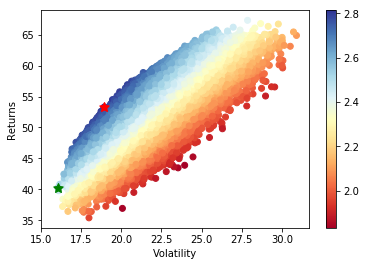

In [11]:
findParallelOptimal(train_data, 1000000)

min_vol_port
ret               40.715391
stdev             15.924027
sharpe             2.556853
NSE:GRAPHITE       0.084550
NSE:GODREJCP       0.109534
NSE:DABUR          0.212998
NSE:PHILIPCARB     0.008623
NSE:ABBOTINDIA     0.278349
NSE:BAJFINANCE     0.070599
NSE:HEG            0.012714
NSE:TATAELXSI      0.051531
NSE:VMART          0.108313
NSE:EDELWEISS      0.046502
NSE:VIPIND         0.016287
Name: 201854, dtype: float64
max_sharpe_port
ret               54.004540
stdev             19.259654
sharpe             2.804024
NSE:GRAPHITE       0.051417
NSE:GODREJCP       0.012339
NSE:DABUR          0.049131
NSE:PHILIPCARB     0.046824
NSE:ABBOTINDIA     0.230301
NSE:BAJFINANCE     0.202800
NSE:HEG            0.083537
NSE:TATAELXSI      0.098178
NSE:VMART          0.132638
NSE:EDELWEISS      0.075691
NSE:VIPIND         0.017144
Name: 92360, dtype: float64


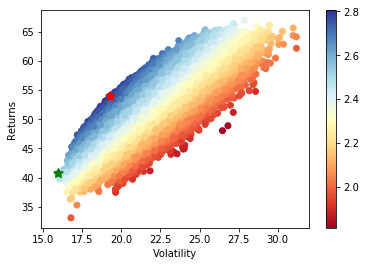

In [12]:
findParallelOptimal(test_data, 1000000)